In [1]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
# 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [42]:
# 데이터셋 로드하기

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32 # 128도 가능
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 데이터셋의 클래스 개수 확인
classes = train_dataset.classes
print(f"데이터셋 클래스 수: {len(classes)}")

Files already downloaded and verified
데이터셋 클래스 수: 100


In [43]:
# GAN  - Generator

class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_dim=32*32*3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), 3, 32, 32)


In [44]:
# GAN -  Discriminator

class Discriminator(nn.Module):
    def __init__(self, img_dim=32*32*3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


In [45]:
# 모델 initialization

latent_dim = 100

generator = Generator(latent_dim)

discriminator = Discriminator()

In [47]:
# 손실 함수 & 옵티마이저 설정

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.00008, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00008, betas=(0.5, 0.999))

In [48]:
# 학습

    # 시각화를 위한 리스트
g_loss_history = []
d_loss_history = []

# 학습
epochs = 50 # gan 뿐만 아니라 cgan에도 적용


for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_data_loader):

        # real image
        real_imgs = imgs
        real_labels = torch.ones(imgs.size(0), 1)

        # created image
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = generator(z)
        fake_labels = torch.zeros(imgs.size(0), 1)

        # Discriminator - train
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Generator - train
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()


    # loss 저장
    g_loss_history.append(g_loss.item())
    d_loss_history.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{epochs}] D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

[Epoch 1/50] D Loss: 0.021477198228240013 | G Loss: 5.132894992828369
[Epoch 2/50] D Loss: 0.0458066463470459 | G Loss: 5.0398664474487305
[Epoch 3/50] D Loss: 0.05860746651887894 | G Loss: 5.315633773803711
[Epoch 4/50] D Loss: 0.12397454679012299 | G Loss: 4.2514543533325195
[Epoch 5/50] D Loss: 0.5885100364685059 | G Loss: 5.347033977508545
[Epoch 6/50] D Loss: 0.2658584415912628 | G Loss: 5.323160171508789
[Epoch 7/50] D Loss: 0.09236645698547363 | G Loss: 4.668304443359375
[Epoch 8/50] D Loss: 0.2062147557735443 | G Loss: 4.784779071807861
[Epoch 9/50] D Loss: 0.12924450635910034 | G Loss: 3.5684893131256104
[Epoch 10/50] D Loss: 0.29304075241088867 | G Loss: 3.6153500080108643
[Epoch 11/50] D Loss: 0.20590971410274506 | G Loss: 3.178154945373535
[Epoch 12/50] D Loss: 0.5170401334762573 | G Loss: 2.772705078125
[Epoch 13/50] D Loss: 0.32081323862075806 | G Loss: 2.535078287124634
[Epoch 14/50] D Loss: 0.3977988362312317 | G Loss: 2.4340267181396484
[Epoch 15/50] D Loss: 0.48955538

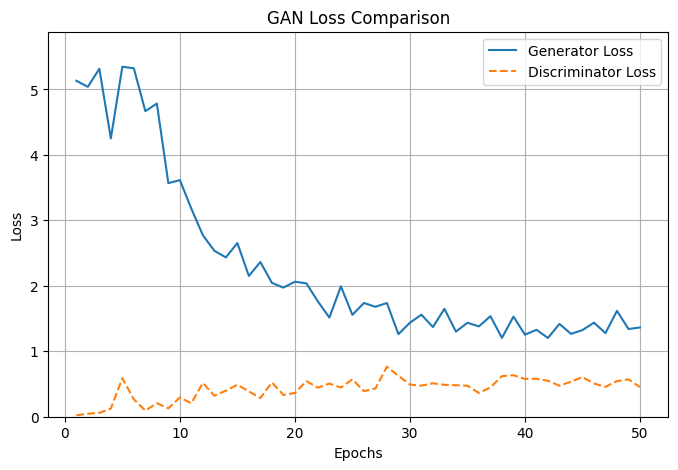

In [49]:
# GAN Generator, Discriminator 시각화

epochs_range = range(1, len(g_loss_history) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, g_loss_history, linestyle='-', label="Generator Loss")
plt.plot(epochs_range, d_loss_history, linestyle='--', label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Loss Comparison")
plt.ylim(0, max(max(g_loss_history), max(d_loss_history)) * 1.1)  # 적절한 y축 범위 설정
plt.legend()
plt.grid(True)
plt.show()

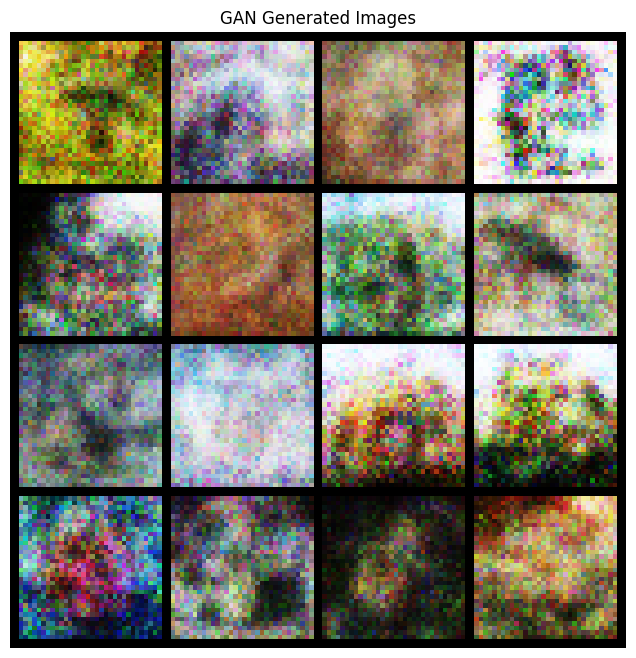

In [50]:
# 생성된 이미지 시각화

# 학습 결과 시각화
def generate_images(generator, num_images=16, latent_dim=100, device = "cuda"):

    generator.to(device) # 오류 해결 : Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

    generator.eval()
    noise = torch.randn(num_images, latent_dim, device=device)

    with torch.no_grad():
        fake_images = generator(noise)

    fake_images = (fake_images + 1) / 2 # 이미지 정규화 해제

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("GAN Generated Images")
    plt.imshow(vutils.make_grid(fake_images.cpu(), nrow=4, padding=2, normalize=False).permute(1, 2, 0))
    plt.show()

# Generator가 학습된 device에 맞게 자동 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generate_images(generator, device=device)

In [51]:
# CGAN generator

class CGAN_Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=100, img_dim=32*32*3):
        super(CGAN_Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_input = self.label_embedding(labels)
        gen_input = torch.cat((z, label_input), dim=1)
        img = self.model(gen_input)
        return img.view(img.size(0), 3, 32, 32)

In [52]:
# CGAN discriminator

class CGAN_Discriminator(nn.Module):
    def __init__(self, num_classes=100, img_dim=32*32*3):
        super(CGAN_Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, img_dim)
        self.model = nn.Sequential(
            nn.Linear(img_dim * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_input = self.label_embedding(labels)
        d_input = torch.cat((img_flat, label_input), dim=1)
        return self.model(d_input)

In [53]:
# 모델 initialization

cgan_generator = CGAN_Generator()
cgan_discriminator = CGAN_Discriminator()

In [54]:
# 학습

g_loss_history_2 = []
d_loss_history_2 = []

for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_data_loader):

        real_imgs = imgs
        real_labels = torch.ones(imgs.size(0), 1)

        # random label
        labels = labels.long()
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = cgan_generator(z, labels)
        fake_labels = torch.zeros(imgs.size(0), 1)

        # Discriminator - train
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(cgan_discriminator(real_imgs, labels), real_labels)
        fake_loss = adversarial_loss(cgan_discriminator(fake_imgs.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # generator - train
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(cgan_discriminator(fake_imgs, labels), real_labels)
        g_loss.backward()
        optimizer_G.step()

    # loss 저장
    g_loss_history_2.append(g_loss.item())
    d_loss_history_2.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{epochs}] D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

[Epoch 1/50] D Loss: 0.6979811191558838 | G Loss: 0.6968135237693787
[Epoch 2/50] D Loss: 0.694639265537262 | G Loss: 0.7012577056884766
[Epoch 3/50] D Loss: 0.6954934597015381 | G Loss: 0.6975624561309814
[Epoch 4/50] D Loss: 0.6920982599258423 | G Loss: 0.6970969438552856
[Epoch 5/50] D Loss: 0.6951640844345093 | G Loss: 0.7010394930839539
[Epoch 6/50] D Loss: 0.6916033625602722 | G Loss: 0.7092901468276978
[Epoch 7/50] D Loss: 0.6913040280342102 | G Loss: 0.687328040599823
[Epoch 8/50] D Loss: 0.6957434415817261 | G Loss: 0.6976316571235657
[Epoch 9/50] D Loss: 0.6947880983352661 | G Loss: 0.7060407996177673
[Epoch 10/50] D Loss: 0.697868287563324 | G Loss: 0.6989649534225464
[Epoch 11/50] D Loss: 0.6941720247268677 | G Loss: 0.6969419121742249
[Epoch 12/50] D Loss: 0.6924442648887634 | G Loss: 0.7001622915267944
[Epoch 13/50] D Loss: 0.6926897168159485 | G Loss: 0.70326828956604
[Epoch 14/50] D Loss: 0.6902819275856018 | G Loss: 0.6930361986160278
[Epoch 15/50] D Loss: 0.6936817169

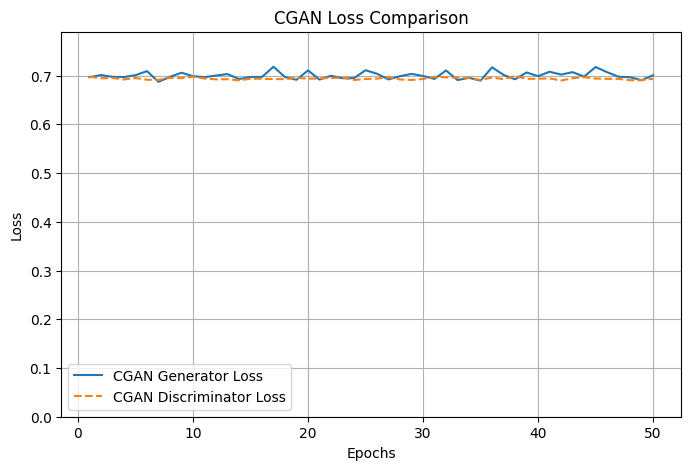

In [55]:
# CGAN Generator, Discriminator 시각화

epochs_range = range(1, len(g_loss_history_2) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, g_loss_history_2, linestyle='-', label="CGAN Generator Loss")
plt.plot(epochs_range, d_loss_history_2, linestyle='--', label="CGAN Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CGAN Loss Comparison")
plt.ylim(0, max(max(g_loss_history_2), max(d_loss_history_2)) * 1.1)
plt.legend()
plt.grid(True)
plt.show()

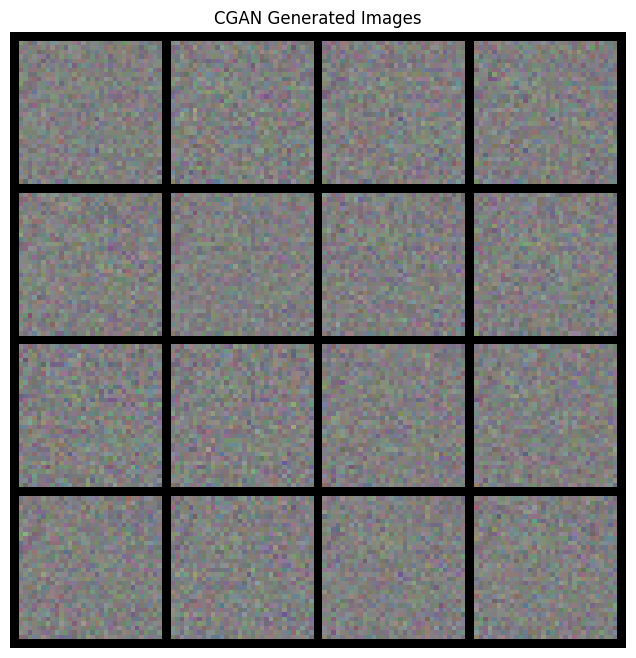

In [56]:
# 생성된 이미지 시각화

# 학습 결과 시각화
def generate_images(generator, num_images=16, latent_dim=100, device = "cuda"):

    generator.to(device) # 오류 해결 : Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

    generator.eval()
    noise = torch.randn(num_images, latent_dim, device=device)



    random_labels = torch.randint(0, 100, (num_images,), device=device) # CGAN_Generator.forward() missing 1 required positional argument: 'labels' : - CGAN의 Generator는 noise와 labels 두 가지 인자가 필요하지만 generate_images() 호출 시 labels 인자를 전달하지 않아서 발생한 오류가 있었음.


    with torch.no_grad():
        fake_images = generator(noise, random_labels)

    fake_images = (fake_images + 1) / 2 # 이미지 정규화 해제

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("CGAN Generated Images")
    plt.imshow(vutils.make_grid(fake_images.cpu(), nrow=4, padding=2, normalize=False).permute(1, 2, 0))
    plt.show()

# Generator가 학습된 device에 맞게 자동 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generate_images(cgan_generator, device=device)




# GAN 분석
GAN의 경우 초반 Epoch에서는 Generator의 손실이 크게 감소하며 이미지 생성 성능이 점진적으로 향상되는 모습을 보였다. 특히 초반 10 Epoch까지 Discriminator가 빠르게 학습하여 Generator와 경쟁적으로 성능이 향상되었으나 중반 이후부터 손실의 진동 폭이 커지며 일부 Epoch에서는 Generator의 손실이 증가하는 불안정한 학습 양상을 보였다.

# 나의 실수
## 생성 이미지에 대한 분석
GAN을 이용해 생성한 이미지는 CIFAR100 데이터셋과 비슷한 구조를 가지며 색상과 기본 형태가 어느 정도(?) 나타났으나 세부 디테일 표현이 부족하였다고 느꼈다. 이는 Generator가 충분히 학습되지 못했거나 Epoch 수가 부족했을 가능성을 시사한다. 학습 속도를 위해 batch size를 크게 하지 않은 것도 결과 정확도면에서 안정성이 떨어졌을 것이라고 본다.

CGAN의 생성 이미지는 예상과 달리 명확한 클래스 구분 없이 매우 노이즈가 많은 형태로 나타났다. 실은 내가 실수한 부분인데, 학습 과정에서 사용한 CGAN 모델의 입력 데이터 처리 과정에서 실수가 있었기 때문으로 추정된다. 옵티마이저 역시 GAN의 설정을 그대로 사용하여 CGAN 학습에 부적합했다. 이러한 문제점을 보완하여 학습을 다시 수행하면 보다 안정적이고 원하는 클래스에 따라 명확한 이미지를 생성할 수 있을 것으로 기대된다.